Dans ce notebook, nous allons essayer de reproduire ce que nous avons fait avec TansorFlow et de réaliser la classification one shot


# Preparation de l'environement

In [4]:
import os
from google.colab import drive
drive.mount("drive/")

Mounted at drive/


In [5]:
os.chdir("/content/drive/MyDrive/HETIC PFA")

In [6]:
!ls 

deeplab1.png  DeepLabv3+_model.png  Models  Raw_Data  removed_bg_data


# Import des bibliothéques

In [7]:
import cv2
import torch
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np

# Fonction pour l'import du model DeepLabv3+




In [159]:
def load_model():
  model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True)
  model.eval()
  return model


# Fonction qui permet de créer l'image transparente de premier plan

In [160]:
def make_transparent_foreground(pic, mask):
  
  b, g, r = cv2.split(np.array(pic).astype('uint8'))
  
  a = np.ones(mask.shape, dtype='uint8') * 255
  
  alpha_im = cv2.merge([b, g, r, a], 4)
 
  bg = np.zeros(alpha_im.shape)
  
  new_mask = np.stack([mask, mask, mask, mask], axis=2)
  
  foreground = np.where(new_mask, alpha_im, bg).astype(np.uint8)

  return foreground


# Fonction pour supprimer l'arrière-plan

In [161]:
def remove_background(model, input_file):
  input_image = Image.open(input_file)
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
  ])

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  # create a binary (black and white) mask of the profile foreground
  mask = output_predictions.byte().cpu().numpy()
  background = np.zeros(mask.shape)
  bin_mask = np.where(mask, 255, background).astype(np.uint8)

  foreground = make_transparent_foreground(input_image ,bin_mask)

  return foreground, bin_mask

In [162]:
#!ls Raw_Data/AD

In [163]:
deeplab_model = load_model()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth


  0%|          | 0.00/42.3M [00:00<?, ?B/s]

In [164]:
foreground, bin_mask = remove_background(deeplab_model, "Raw_Data/AD/photo 16.jpg")

In [165]:
bin_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

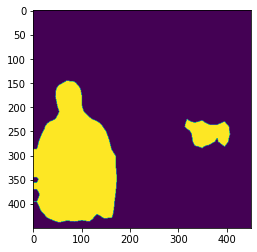

In [166]:
plt.imshow(bin_mask)

In [167]:
print(bin_mask.shape)
print(foreground.shape)

(450, 450)
(450, 450, 4)


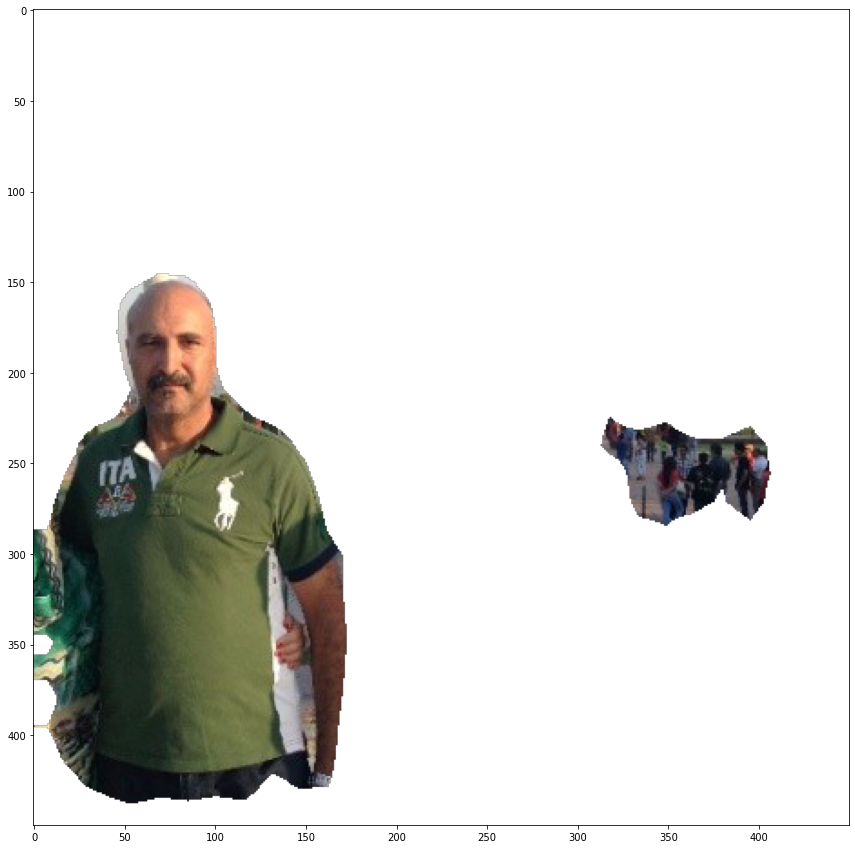

In [168]:
plt.figure(figsize=(20,15))
plt.imshow(foreground)

# Test 2 

In [119]:
import torch
import numpy as np
import urllib
from PIL import Image
from torchvision import transforms

model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()
print("model loaded")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


model loaded


In [124]:

# Download an example image from the pytorch website
filename = "Raw_Data/AD/photo 16.jpg"
input_image = Image.open(filename)

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

postprocess = transforms.Compose([
    transforms.Normalize(mean=-mean/std, std=1/std),
    transforms.ToPILImage(),
])

if torch.cuda.is_available():
    model.to('cuda')

In [128]:
def remove_background(img, model):
    input_batch = preprocess(img)[None, ...]
    
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')

    with torch.no_grad():
        output = model(input_batch)['out'][0]
        output_predictions = torch.nn.functional.softmax(output, dim=0)

    img.putalpha(255)
    result_np = np.array(img)
    result_np[..., 3] = (1-output_predictions[0].cpu().numpy())*255
    
    return Image.fromarray(result_np.astype('uint8'))

In [129]:
import time
img = input_image.copy()

start_time = time.time()
result = remove_background(img, model)
print('time elapsed: {}'.format(time.time()-start_time))

time elapsed: 7.922718048095703


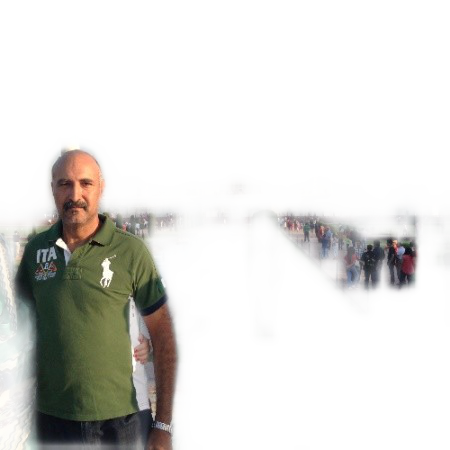

In [130]:
# show result
result